In [1]:
import glob as glob
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
from joblib import Parallel, delayed
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

In [2]:
paths = sorted(glob.glob('../data/*LegMeanStats*'))

In [3]:
bl = []
for i in range(1,57):
    bl.append(f'bin_{i:02d}')

In [14]:
f

<xarray.Dataset> Size: 272kB
Dimensions:            (time: 39, bounds: 2, percentiles: 7,
                        SuperSaturation: 6, size_CN: 56, size_Nd: 18)
Coordinates:
  * time               (time) datetime64[ns] 312B 2022-06-18T12:06:10 ... 202...
  * bounds             (bounds) <U3 24B 'min' 'max'
  * size_CN            (size_CN) float64 448B 3.2 3.5 ... 2.512e+03 3.162e+03
  * size_Nd            (size_Nd) float64 144B 3.75 5.25 7.0 ... 40.5 44.0 48.0
  * percentiles        (percentiles) int32 28B 5 10 25 50 75 90 95
  * SuperSaturation    (SuperSaturation) float64 48B 0.1 0.2 0.3 0.5 0.6 0.37
Data variables: (12/88)
    LegIndex           (time) int64 312B ...
    lat                (time) float64 312B ...
    lon                (time) float64 312B ...
    alt                (time) float64 312B ...
    alt_std            (time) float64 312B ...
    time_bnds          (bounds, time) datetime64[ns] 624B 2022-06-18T12:05:15...
    ...                 ...
    std_CNbin          (size_CN, time) float64 17kB ...
    pct_CNbin          (percentiles, size_CN, time) float64 122kB ...
    CN_continue_flag   (time) int16 78B ...
    dNdlogD_Nd         (size_Nd, time) float64 6kB ...
    std_Ndbin          (size_Nd, time) float64 6kB ...
    pct_Ndbin          (percentiles, size_Nd, time) float64 39kB ...
Attributes: (12/16)
    title:                leg-averaged statistical and analysis data from Fal...
    project:              ACTIVATE
    platform_identifier:  HU25
    flight_start_date:    20220618
    statistics:           mean, [5,10,25,50,75,90,95] percentiles, min/max bo...
    Measured_CCN:         Measured CCN binned for specific supersaturations: ...
    ...                   ...
    history:              R0: first released data.
    data_source:          ['ACTIVATE-SUMMARY_HU25_20220618_R1.ict', 'ACTIVATE...
    Conventions:          CF-1.10
    contact:              Shuaiqi Tang (shuaiqi.tang@pnnl.gov); Hailong Wang ...
    institution:          Pacific Northwest National Laboratory
    last_modified_date:   Wed Feb  7 11:52:31 2024

In [4]:
start_time = []
end_time = []
f_d = [] # file data
for i in range(0,len(paths)):
    f = xr.open_dataset(paths[i]) # open each file

    additional_dict = {key: f['dNdlogD_CN'].values[j,:] for j, key in enumerate(bl)}
    # extract data
    time_bound = f.time_bnds.values
    f_d.append(pd.DataFrame({'Time_Start': time_bound[::2][0],'Time_Stop': time_bound[1::2][0],
    'CCN_obs_1':f['ccn1_measure'].values, 'CCN_obs_2':f['ccn2_measure'].values, 'CCN_obs_3':f['ccn3_measure'].values, 'CCN_obs_5':f['ccn5_measure'].values, 'CCN_obs_6':f['ccn6_measure'].values, 'CCN_obs_37':f['ccn37_measure'].values,
    'CCN_calc_1': f['ccn_calc_ams'].values[:,0], 'CCN_calc_2': f['ccn_calc_ams'].values[:,1], 'CCN_calc_3': f['ccn_calc_ams'].values[:,2], 'CCN_calc_5': f['ccn_calc_ams'].values[:,3], 'CCN_calc_6': f['ccn_calc_ams'].values[:,4], 'CCN_calc_37': f['ccn_calc_ams'].values[:,5],
    'k_calc' : f['hygro_calc'].values, 'SS':f['SS_calc_hygro'].values, **additional_dict}))

d = pd.concat(f_d).reset_index(drop=True)

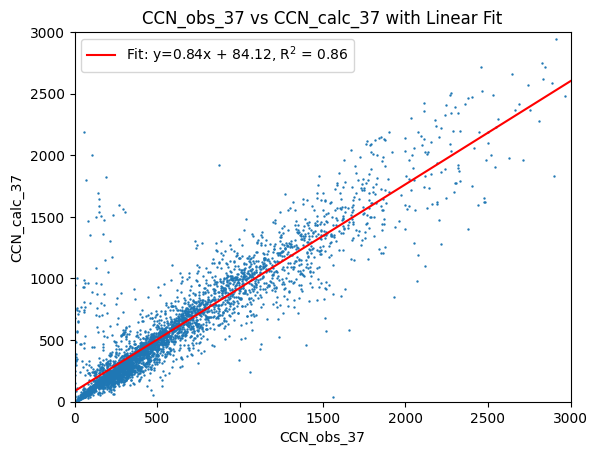

In [5]:
# Scatter plot of the data
plt.scatter(d['CCN_obs_37'], d['CCN_calc_37'], s=0.5)
plt.xlim([0, 3000])
plt.ylim([0, 3000])

d_sub = d.dropna(subset=['CCN_obs_37', 'CCN_calc_37'])
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(d_sub['CCN_obs_37'], d_sub['CCN_calc_37'])

# Create line data
x_vals = np.array([0, 3000])
y_vals = intercept + slope * x_vals

# Plot the fitted line
plt.plot(x_vals, y_vals, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}, R$^2$ = {r_value:.2f}')
plt.legend()
plt.xlabel('CCN_obs_37')
plt.ylabel('CCN_calc_37')
plt.title('CCN_obs_37 vs CCN_calc_37 with Linear Fit')
plt.show()

In [6]:
bl = []
for i in range(1,57):
    bl.append(f'bin_{i:02d}')
len(f['dNdlogD_CN'].values[0:])

56

In [7]:
def simple_read(path):
    '''
    Reads .ict files to a Pandas DataFrame
    :param path: path to the .ict data
    :return: Pandas DataFrame with .ict data
    '''
    with open(path) as f:
        # find the value in the file which tells you how many lines to skip to get to the table
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
    data = pd.read_csv(path, sep=',', skiprows=header_line)

    # finds the location in the path containing the date
    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
        
    # creates datetime object with the date the data was collected
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8])) 
    
    for column in data.keys():
        if 'Time' in column:
            # converts seconds after midnight columns to datetime
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    data.columns = data.columns.str.replace(' ', '')
    return data.replace(-9999, np.nan) # Converts -9999 values to NaN


def add_leg(data, legs):
    '''
    add leg to the data file
    :param data: pandas data
    :param legs: pandas legs data
    :return: Pandas DataFrame with legs
    '''
    data=data.copy()
    # creates leg column
    data['leg'] = np.nan

    # leg codes corresponding to each leg type
    leg_key = {'00':'Takeoff/Landing', '01':'Transit', '02':'BCB', '03':'ACB', '04':'BCT', '05':'ACT', '06':'MinAlt', '07':'Ascent', '08':'Descent', '09':'Slant/Spiral', '10':'BBL', '11':'ABL', '12':'Remote Sensing (HSRL-2)', '13':'Other'}

    data = data.astype({'leg': 'str'})
    for i in range(0, len(legs)):
        subset = data[(data['Time_Start'] >= legs.iloc[i]['Time_Start']) & (data['Time_Stop'] <= legs.iloc[i]['Time_Stop'])].copy()
        subset['leg'] = leg_key[str(legs.iloc[i]['LegIndex'])[-2:]]
        data.loc[subset.index, 'leg'] = subset['leg']

    return data

In [8]:
# reads each file type
# all data is saved in the data folder within the github repository
ccn_paths = sorted(glob.glob('../data/*CCN*'))
master_ccn = []
for i in range(0, len(ccn_paths)):
    master_ccn.append(simple_read(ccn_paths[i]))
master_ccn = pd.concat(master_ccn).reset_index()
ams_paths = sorted(glob.glob('../data/*AMS_*'))
master_ams = []
for i in range(0, len(ams_paths)):
    master_ams.append(simple_read(ams_paths[i]))
master_ams = pd.concat(master_ams).reset_index()
las_paths = sorted(glob.glob('../data/*LAS*'))
master_las = []
for i in range(0, len(las_paths)):
    master_las.append(simple_read(las_paths[i]))
master_las = pd.concat(master_las).reset_index()
smps_paths = sorted(glob.glob('../data/*SMPS*'))
master_smps = []
for i in range(0, len(smps_paths)):
    master_smps.append(simple_read(smps_paths[i]))
master_smps = pd.concat(master_smps).reset_index()
sum_paths = sorted(glob.glob('../data/*SUMMARY*'))
master_sum = []
for i in range(0, len(sum_paths)):
    master_sum.append(simple_read(sum_paths[i]))
master_sum = pd.concat(master_sum).reset_index().rename(columns={'Time_mid':'Time_Mid'})
leg_paths = sorted(glob.glob('../data/*LegFlags*'))
master_leg = []
for i in range(0, len(leg_paths)):
    master_leg.append(simple_read(leg_paths[i]))
master_leg = pd.concat(master_leg).reset_index()
d = add_leg(d, master_leg)
fcdp_paths = sorted(glob.glob('../data/*FCDP*'))
master_fcdp = []
for i in range(0, len(fcdp_paths)):
    master_fcdp.append(simple_read(fcdp_paths[i]))
master_fcdp = pd.concat(master_fcdp).reset_index()
master_fcdp = master_fcdp[['Time_Start', 'LWC_FCDP']]
v_paths = sorted(glob.glob('../data/*2DS-V*'))
master_v = []
for i in range(0, len(v_paths)):
    master_v.append(simple_read(v_paths[i]))
master_v = pd.concat(master_v).reset_index()
master_2ds = master_v[['Time_Start', 'ED-liquid_2DS', 'Ice_Flag_2DS']]
co_paths = sorted(glob.glob('../data/*CO_*'))
master_co = []
for i in range(0, len(co_paths)):
    master_co.append(simple_read(co_paths[i]))
master_co = pd.concat(master_co).reset_index()
master_co = master_co[['Time_Start', 'Time_Stop', 'CO_ppm']]

In [9]:
def process_row(i):
    # finds the mean/median/max using the SMPS start and end times (because that has the lowest time resolution)
    row = d.iloc[i]
    t_start = row['Time_Start']
    t_stop = row['Time_Stop']
    smps_row = master_smps[(master_smps['Time_Start'] >= t_start) & (master_smps['Time_Stop'] <= t_stop)].mean(numeric_only=True)
    ccn_row = master_ccn[(master_ccn['Time_mid'] >= t_start) & (master_ccn['Time_mid'] <= t_stop)].mean(numeric_only=True)
    las_row = master_las[(master_las['Time_Start'] >= t_start) & (master_las['Time_Start'] <= t_stop)].mean(numeric_only=True)
    ams_row = master_ams[(master_ams['Time_Start'] >= t_start-timedelta(seconds=5)) & (master_ams['Time_Stop'] <= t_stop+timedelta(seconds=5))].mean(numeric_only=True)
    sum_row = master_sum[(master_sum['Time_Mid'] >= t_start) & (master_sum['Time_Mid'] <= t_stop)].mean(numeric_only=True)
    fcdp_row = master_fcdp[(master_fcdp['Time_Start'] >= t_start) & (master_fcdp['Time_Start'] <= t_stop)].max(numeric_only=True)
    v_row = master_2ds[(master_2ds['Time_Start'] >= t_start) & (master_2ds['Time_Start'] <= t_stop)].max(numeric_only=True)
    co_row = master_co[(master_co['Time_Start'] >= t_start) & (master_co['Time_Stop'] <= t_stop)].mean(numeric_only=True)
    return smps_row, ccn_row, las_row, ams_row, sum_row, fcdp_row, v_row, co_row

results = Parallel(n_jobs=-1)(delayed(process_row)(i) for i in tqdm(range(0, len(d))))

smps_mean, ccn_mean, las_mean, ams_mean, sum_mean, fcdp_mean, v_mean, co_mean = zip(*results)
smps_mean = pd.DataFrame(list(smps_mean))
ccn_mean = pd.DataFrame(list(ccn_mean))
las_mean = pd.DataFrame(list(las_mean))
ams_mean = pd.DataFrame(list(ams_mean))
sum_mean = pd.DataFrame(list(sum_mean))
fcdp_mean = pd.DataFrame(list(fcdp_mean))
v_mean = pd.DataFrame(list(v_mean))
co_mean = pd.DataFrame(list(co_mean))

  0%|          | 0/7361 [00:00<?, ?it/s]

100%|██████████| 7361/7361 [02:41<00:00, 45.58it/s]


In [10]:
# Merging specified columns into the merged DataFrame
merged = pd.merge(d, smps_mean[['SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04',
       'SMPS_Bin05', 'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09',
       'SMPS_Bin10', 'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14',
       'SMPS_Bin15', 'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19',
       'SMPS_Bin20', 'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24',
       'SMPS_Bin25', 'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29',
       'SMPS_Bin30']], left_index=True, right_index=True)
merged = pd.merge(merged, ams_mean[['Org_Ave_IsoK_STP', 'SO4_Ave_IsoK_STP',
       'NO3_Ave_IsoK_STP', 'NH4_Ave_IsoK_STP', 'Chl_Ave_IsoK_STP',
       'mz42_Ave_IsoK_STP', 'mz43_Ave_IsoK_STP', 'mz44_Ave_IsoK_STP',
       'mz55_Ave_IsoK_STP', 'mz57_Ave_IsoK_STP', 'mz58_Ave_IsoK_STP',
       'mz60_Ave_IsoK_STP', 'mz79_Ave_IsoK_STP', 'mz91_Ave_IsoK_STP']], left_index=True, right_index=True)
merged = pd.merge(merged, ccn_mean[['CCN_SS', 'N_CCN_stdPT']], left_index=True, right_index=True)
merged = pd.merge(merged, las_mean[['LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04', 'LAS_Bin05',
       'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09', 'LAS_Bin10',
       'LAS_Bin11', 'LAS_Bin12', 'LAS_Bin13', 'LAS_Bin14', 'LAS_Bin15',
       'LAS_Bin16', 'LAS_Bin17', 'LAS_Bin18', 'LAS_Bin19', 'LAS_Bin20',
       'LAS_Bin21', 'LAS_Bin22', 'LAS_Bin23', 'LAS_Bin24', 'LAS_Bin25',
       'LAS_Bin26']], left_index=True, right_index=True)
merged = pd.merge(merged, sum_mean[['Latitude', 'Longitude', 'GPS_altitude',
       'Pressure_Altitude', 'Pitch', 'Roll', 'True_Heading', 'True_Air_Speed',
       'Static_Air_Temp', 'IR_Surf_Temp', 'Static_Pressure', 'Wind_Speed',
       'Wind_Direction']], left_index=True, right_index=True)
merged = pd.merge(merged, fcdp_mean[['LWC_FCDP']], left_index=True, right_index=True)
merged = pd.merge(merged, v_mean[['ED-liquid_2DS', 'Ice_Flag_2DS']], left_index=True, right_index=True)
merged = pd.merge(merged, co_mean[['CO_ppm']], left_index=True, right_index=True)

In [11]:
merged['Time_Mid'] = merged['Time_Start'] + (merged['Time_Stop'] - merged['Time_Start'])/2

In [12]:
# save the data into a table
merged.to_csv('../tables/merged_pnnl.csv', index=False)